### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import glob
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

### Create files dataframe

In [2]:
files_df = pd.DataFrame({'path':glob.glob('data\\**\\*.csv')}).reset_index(drop=True)
files_df['type'] = files_df['path'].apply(lambda x: x.split('\\')[1])
files_df['id'] = files_df['path'].apply(lambda x: x.split('\\')[-1].split('.')[0])

In [3]:
files_df.head()

,path,type,id
0,data\idle\idle-1.csv,idle,idle-1
1,data\idle\idle-10.csv,idle,idle-10
2,data\idle\idle-100.csv,idle,idle-100
3,data\idle\idle-1000.csv,idle,idle-1000
4,data\idle\idle-1001.csv,idle,idle-1001


In [4]:
files_df.groupby('type').size().reset_index(name='amount')

,type,amount
0,idle,1039
1,running,3408
2,stairs,165
3,walking,1850


### Create dataframe containing all files

In [5]:
def CreateDF(files):
    data_samples = []

    for arg in tqdm(files.values):
        sample = pd.read_csv(arg[0])

        assert len(sample) == 30

        sample['id'] = arg[2]
        sample['sub_id'] = np.arange(30)
        sample['type'] = arg[1]

        data_samples.append(sample)
    
    return pd.concat(data_samples, axis=0, sort=False)

In [6]:
data_df = CreateDF(files_df)

  0%|          | 0/6462 [00:00<?, ?it/s]

In [7]:
data_df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,id,sub_id,type
0,1.000776,4.616021,8.576031,idle-1,0,idle
1,0.718261,4.209007,8.446744,idle-1,1,idle
2,-0.909797,-0.282516,9.203311,idle-1,2,idle
3,5.099650,0.148441,8.418014,idle-1,3,idle
4,1.762132,-0.162806,9.251195,idle-1,4,idle


### Check dataframe statistics

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193860 entries, 0 to 29
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   id               193860 non-null  object 
 4   sub_id           193860 non-null  int32  
 5   type             193860 non-null  object 
dtypes: float64(3), int32(1), object(2)
memory usage: 9.6+ MB


<i>Data has no NA's</i>

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
accelerometer_X,193860.0,1.923550,8.404867,-39.188293,-2.494758,0.248997,4.668694,39.188293
accelerometer_Y,193860.0,1.598343,12.474041,-39.188293,-8.327033,-0.009577,8.671799,39.188293
accelerometer_Z,193860.0,1.804896,7.191590,-39.188293,-2.494758,0.905008,7.187394,39.188293
sub_id,193860.0,14.500000,8.655464,0.000000,7.000000,14.500000,22.000000,29.000000


In [10]:
data_df.groupby('type').describe().T

type                           idle        running       stairs       walking
accelerometer_X count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       0.096767       5.045705     0.353135     -2.661943
                std        0.691892       9.952696     3.845949      4.648378
                min      -10.448297     -39.188293   -11.238382    -26.815060
                25%       -0.110133      -1.532289    -1.857900     -4.855441
                50%        0.234632       3.605668     0.483629     -2.298433
                75%        0.277727       9.595961     2.600103     -0.229843
                max        8.135497      39.188293    14.164097     20.575770
accelerometer_Y count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       2.225971       8.083135    -9.574353     -9.703702
                std        2.821235      12.441402     4.922294      5.931165
                min       -2.595315     -39.188293   -25.828648    -39.188293
                25%       -0.028730      -0.742202   -12.253524    -13.369223
                50%        0.028730       7.967903    -8.944737     -9.974244
                75%        5.310340      16.385916    -6.301539     -6.540959
                max        9.916783      39.188293     4.994305     14.441825
accelerometer_Z count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       8.973247       1.387356    -1.841333     -1.126623
                std        1.211058       7.004236     5.297376      6.927679
                min       -0.296881     -39.188293   -38.086960    -39.169140
                25%        8.116344      -2.873042    -3.797204     -3.428497
                50%        9.749189       0.407014    -1.589750     -0.933739
                75%        9.773131       4.769250     0.292093      1.561020
                max       21.988348      39.188293    17.492037     38.426937
sub_id          count  31170.000000  102240.000000  4950.000000  55500.000000
                mean      14.500000      14.500000    14.500000     14.500000
                std        8.655580       8.655484     8.656316      8.655519
                min        0.000000       0.000000     0.000000      0.000000
                25%        7.000000       7.000000     7.000000      7.000000
                50%       14.500000      14.500000    14.500000     14.500000
                75%       22.000000      22.000000    22.000000     22.000000
                max       29.000000      29.000000    29.000000     29.000000

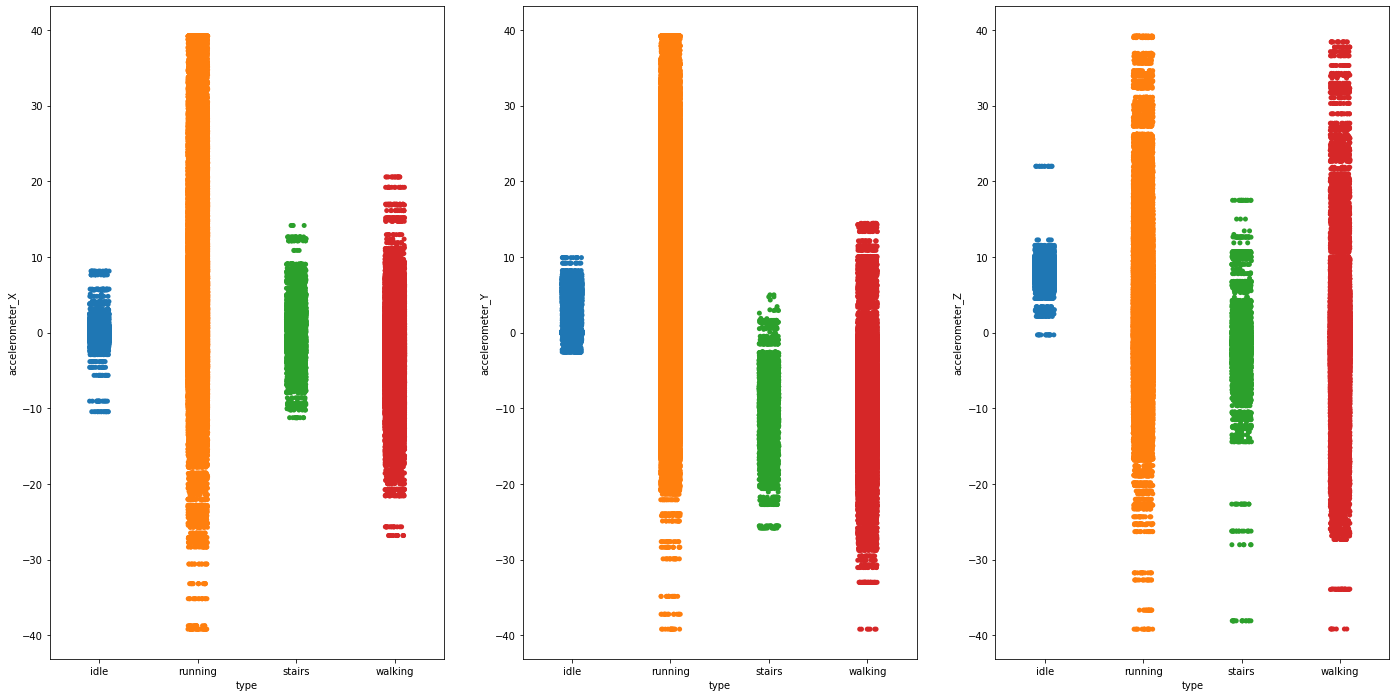

In [11]:
fig=plt.figure(figsize=(24,12))
ax1=fig.add_subplot(131)
ax1=sns.stripplot(x='type',y='accelerometer_X',data=data_df,jitter=True)

ax2=fig.add_subplot(132)
ax2=sns.stripplot(x='type',y='accelerometer_Y',data=data_df,jitter=True)

ax3=fig.add_subplot(133)
ax3=sns.stripplot(x='type',y='accelerometer_Z',data=data_df,jitter=True)

plt.show()

<i>Data contains outliers</i>

### Train test split

In [12]:
def TrainTestSplit(df):
    train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['type'], random_state=0)
    print('Train size: {}\nTest size: {}'.format(len(train_df), len(test_df)))
    return train_df, test_df

In [13]:
train_df_ids, test_df_ids = TrainTestSplit(files_df)

Train size: 5815
Test size: 647


In [14]:
train_df = CreateDF(train_df_ids)
test_df = CreateDF(test_df_ids)

  0%|          | 0/5815 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

### Features generation

<i>Take all X, Y, Z accelerometer values (3 $\times$ 30)</i>

In [15]:
def FlattenDF(df):
    cols = [col for col in df.columns if col.startswith('accelerometer')]
    sub_ids = [str(i) for i in range(30)]

    flatten_DFs = []
    for sub_df in tqdm([v for k, v in df.groupby('id')]):
        temp = sub_df.pivot(index='id', columns='sub_id', values=cols).reset_index(drop=True)     
        temp.columns = list(map('_'.join, itertools.product(cols, sub_ids)))
        temp['type'] = sub_df['type'].iloc[0]
        flatten_DFs.append(temp)
    return pd.concat(flatten_DFs, axis=0, sort=False).reset_index(drop=True)

In [16]:
flatten_train_df = FlattenDF(train_df)
flatten_test_df = FlattenDF(test_df)

  0%|          | 0/5815 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

In [17]:
flatten_train_df.columns

Index(['accelerometer_X_0', 'accelerometer_X_1', 'accelerometer_X_2',
       'accelerometer_X_3', 'accelerometer_X_4', 'accelerometer_X_5',
       'accelerometer_X_6', 'accelerometer_X_7', 'accelerometer_X_8',
       'accelerometer_X_9', 'accelerometer_X_10', 'accelerometer_X_11',
       'accelerometer_X_12', 'accelerometer_X_13', 'accelerometer_X_14',
       'accelerometer_X_15', 'accelerometer_X_16', 'accelerometer_X_17',
       'accelerometer_X_18', 'accelerometer_X_19', 'accelerometer_X_20',
       'accelerometer_X_21', 'accelerometer_X_22', 'accelerometer_X_23',
       'accelerometer_X_24', 'accelerometer_X_25', 'accelerometer_X_26',
       'accelerometer_X_27', 'accelerometer_X_28', 'accelerometer_X_29',
       'accelerometer_Y_0', 'accelerometer_Y_1', 'accelerometer_Y_2',
       'accelerometer_Y_3', 'accelerometer_Y_4', 'accelerometer_Y_5',
       'accelerometer_Y_6', 'accelerometer_Y_7', 'accelerometer_Y_8',
       'accelerometer_Y_9', 'accelerometer_Y_10', 'accelerometer_Y_11'

<i>Generate features by replacing X, Y, Z accelerometer values with their corresponding location measures (mean, std, min, 1st quartile, median, 3rd quartile, max)</i>

In [18]:
def first_quartile(arr):
    return arr.quantile(0.25)

def third_quartile(arr):
    return arr.quantile(0.75)

def LocationMesuresDF(df):
    cols = [col for col in df.columns if col.startswith('accelerometer')]
    loc_funcs = [np.mean, np.median, np.min, first_quartile, np.median, third_quartile, np.max]
    
    loc_mes_DFs = []
    for sub_df in tqdm([v for k, v in df.groupby('id')]):     
        temp = pd.DataFrame()        
        
        for col in cols:
            for f in loc_funcs:
                temp[col + '_' + f.__name__] = [f(sub_df[col])]
                
        temp['type'] = sub_df['type'].iloc[0]
        loc_mes_DFs.append(temp)
        
    return pd.concat(loc_mes_DFs, axis=0, sort=False).reset_index(drop=True)

In [19]:
loc_mes_train_df = LocationMesuresDF(train_df)
loc_mes_test_df = LocationMesuresDF(test_df)

  0%|          | 0/5815 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

In [20]:
loc_mes_train_df.columns

Index(['accelerometer_X_mean', 'accelerometer_X_median',
       'accelerometer_X_amin', 'accelerometer_X_first_quartile',
       'accelerometer_X_third_quartile', 'accelerometer_X_amax',
       'accelerometer_Y_mean', 'accelerometer_Y_median',
       'accelerometer_Y_amin', 'accelerometer_Y_first_quartile',
       'accelerometer_Y_third_quartile', 'accelerometer_Y_amax',
       'accelerometer_Z_mean', 'accelerometer_Z_median',
       'accelerometer_Z_amin', 'accelerometer_Z_first_quartile',
       'accelerometer_Z_third_quartile', 'accelerometer_Z_amax', 'type'],
      dtype='object')

<i>Generate features by applying PCA to each data sample</i>

In [21]:
def ReducedDimensionDF(df, newDim): 
    cols = [col for col in df.columns if col.startswith('accelerometer')]
    new_cols = ['accelerometer_' + str(i) for i in range(newDim)]
    
    reduced_dim_DFs = []
    
    explained_variances = []
    
    for sub_df in tqdm([v for k, v in df.groupby('id')]):     
        temp = pd.DataFrame()        
        raw_data = sub_df.drop(['id', 'sub_id', 'type'], axis=1).to_numpy()
        pca = PCA(n_components=newDim)
        pca_data = pca.fit_transform(raw_data)
                
        explained_variances.append(np.sum(pca.explained_variance_ratio_))
        temp[new_cols] = pca_data

        temp['type'] = sub_df['type'].iloc[0]
        temp['id'] = sub_df['id'].iloc[0]
        temp['sub_id'] = sub_df['sub_id']

        reduced_dim_DFs.append(temp)
        
    print('Explained variance ratios mean:', np.mean(explained_variances))
    print('Explained variance ratios median:', np.median(explained_variances))
    print('Explained variance ratios min:', np.min(explained_variances))
    print('Explained variance ratios max:', np.max(explained_variances))
        
    result_df = pd.concat(reduced_dim_DFs, axis=0, sort=False).reset_index(drop=True)
    
    return result_df

In [22]:
pca_2d_train_df = FlattenDF(ReducedDimensionDF(train_df, 2))
pca_2d_test_df = FlattenDF(ReducedDimensionDF(test_df, 2))

  0%|          | 0/5815 [00:00<?, ?it/s]

Explained variance ratios mean: 0.9018696348562061
Explained variance ratios median: 0.9042531685272375
Explained variance ratios min: 0.7422493541230686
Explained variance ratios max: 0.9997663517389832


  0%|          | 0/5815 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

Explained variance ratios mean: 0.9050678259441377
Explained variance ratios median: 0.9080562803572501
Explained variance ratios min: 0.7378743000763284
Explained variance ratios max: 0.9980466080410594


  0%|          | 0/647 [00:00<?, ?it/s]

In [23]:
pca_2d_train_df.columns

Index(['accelerometer_0_0', 'accelerometer_0_1', 'accelerometer_0_2',
       'accelerometer_0_3', 'accelerometer_0_4', 'accelerometer_0_5',
       'accelerometer_0_6', 'accelerometer_0_7', 'accelerometer_0_8',
       'accelerometer_0_9', 'accelerometer_0_10', 'accelerometer_0_11',
       'accelerometer_0_12', 'accelerometer_0_13', 'accelerometer_0_14',
       'accelerometer_0_15', 'accelerometer_0_16', 'accelerometer_0_17',
       'accelerometer_0_18', 'accelerometer_0_19', 'accelerometer_0_20',
       'accelerometer_0_21', 'accelerometer_0_22', 'accelerometer_0_23',
       'accelerometer_0_24', 'accelerometer_0_25', 'accelerometer_0_26',
       'accelerometer_0_27', 'accelerometer_0_28', 'accelerometer_0_29',
       'accelerometer_1_0', 'accelerometer_1_1', 'accelerometer_1_2',
       'accelerometer_1_3', 'accelerometer_1_4', 'accelerometer_1_5',
       'accelerometer_1_6', 'accelerometer_1_7', 'accelerometer_1_8',
       'accelerometer_1_9', 'accelerometer_1_10', 'accelerometer_1_11'

In [24]:
pca_2d_loc_mes_train_df = LocationMesuresDF(ReducedDimensionDF(train_df, 2))
pca_2d_loc_mes_test_df = LocationMesuresDF(ReducedDimensionDF(test_df, 2))

  0%|          | 0/5815 [00:00<?, ?it/s]

Explained variance ratios mean: 0.9018696348562061
Explained variance ratios median: 0.9042531685272375
Explained variance ratios min: 0.7422493541230686
Explained variance ratios max: 0.9997663517389832


  0%|          | 0/5815 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

Explained variance ratios mean: 0.9050678259441377
Explained variance ratios median: 0.9080562803572501
Explained variance ratios min: 0.7378743000763284
Explained variance ratios max: 0.9980466080410594


  0%|          | 0/647 [00:00<?, ?it/s]

In [25]:
pca_2d_loc_mes_train_df.columns

Index(['accelerometer_0_mean', 'accelerometer_0_median',
       'accelerometer_0_amin', 'accelerometer_0_first_quartile',
       'accelerometer_0_third_quartile', 'accelerometer_0_amax',
       'accelerometer_1_mean', 'accelerometer_1_median',
       'accelerometer_1_amin', 'accelerometer_1_first_quartile',
       'accelerometer_1_third_quartile', 'accelerometer_1_amax', 'type'],
      dtype='object')

### Baseline models

<i>Logistic regression</i>

In [26]:
def DisplayInfo(X, y, clf, title, labels):
    print('{} score: {}'.format(title, clf.score(X, y)))
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(confusion_matrix(y, clf.predict(X)), display_labels=labels
                          ).plot(cmap=plt.cm.Blues, values_format='.0f', ax=ax)
    ax.set_title(title)
    plt.show()

def LogisticRegresion(df_train, df_test):
    cols = [col for col in df_train.columns if col.startswith('accelerometer')]
    
    X_train = df_train[cols].to_numpy()
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    
    y_train = df_train['type'].to_numpy()   
        
    X_test = scaler.transform(df_test[cols].to_numpy())
    y_test = df_test['type'].to_numpy()
    
    clf = sklearn.linear_model.LogisticRegression(max_iter=500, random_state=0).fit(X_train, y_train)
    
    DisplayInfo(X_train, y_train, clf, 'Cross Validation result', df_train['type'].unique())
    DisplayInfo(X_test, y_test, clf, 'Test result', df_train['type'].unique())    

Cross Validation result score: 0.9829750644883921


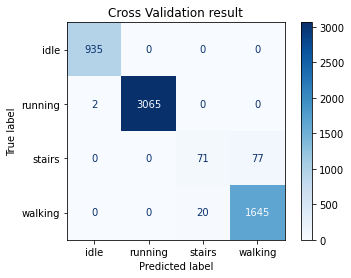

Test result score: 0.973724884080371


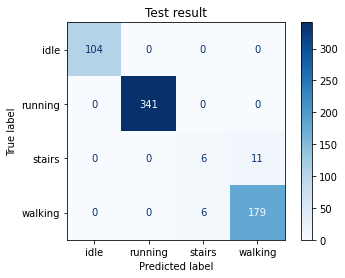

In [27]:
LogisticRegresion(flatten_train_df, flatten_test_df)

Cross Validation result score: 0.989853826311264


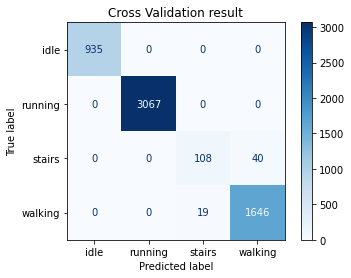

Test result score: 0.9860896445131375


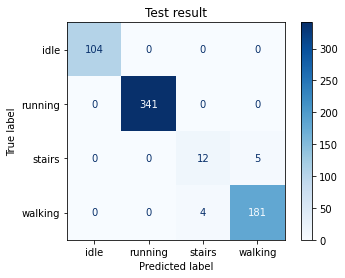

In [28]:
LogisticRegresion(loc_mes_train_df, loc_mes_test_df)

Cross Validation result score: 0.5270851246775581


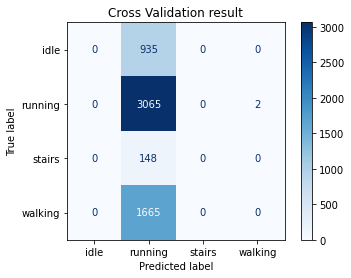

Test result score: 0.5239567233384853


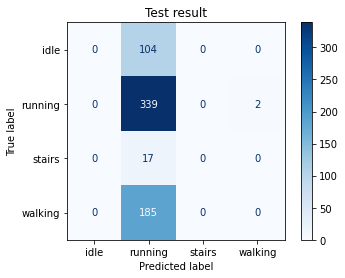

In [29]:
LogisticRegresion(pca_2d_train_df, pca_2d_test_df)

Cross Validation result score: 0.9649183147033534


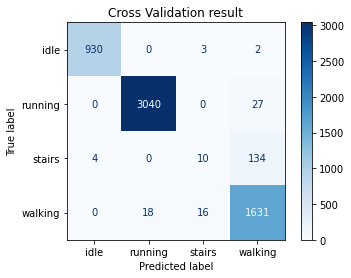

Test result score: 0.9598145285935085


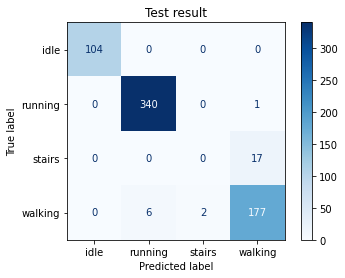

In [30]:
LogisticRegresion(pca_2d_loc_mes_train_df, pca_2d_loc_mes_test_df)

<i>SVM</i>

In [31]:
def SVM(df_train, df_test):
    cols = [col for col in df_train.columns if col.startswith('accelerometer')]
    
    X_train = df_train[cols].to_numpy()
    y_train = df_train['type'].to_numpy()   
        
    X_test = df_test[cols].to_numpy()
    y_test = df_test['type'].to_numpy()
    
    clf = sklearn.svm.SVC(random_state=0).fit(X_train, y_train)
    
    DisplayInfo(X_train, y_train, clf, 'Cross Validation result', df_train['type'].unique())
    DisplayInfo(X_test, y_test, clf, 'Test result', df_train['type'].unique())  

Cross Validation result score: 0.9879621668099742


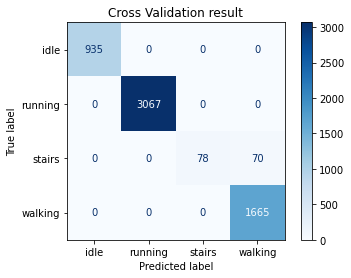

Test result score: 0.9860896445131375


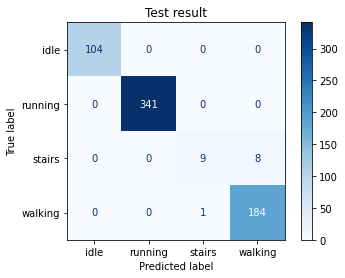

In [32]:
SVM(flatten_train_df, flatten_test_df)

Cross Validation result score: 0.9915735167669819


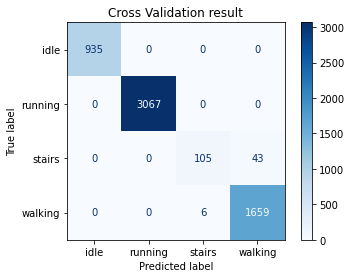

Test result score: 0.9876352395672334


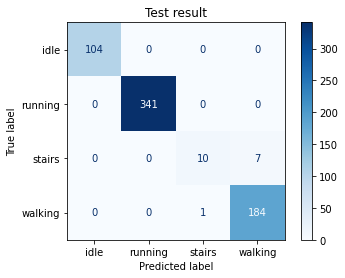

In [33]:
SVM(loc_mes_train_df, loc_mes_test_df)

Cross Validation result score: 0.9662940670679278


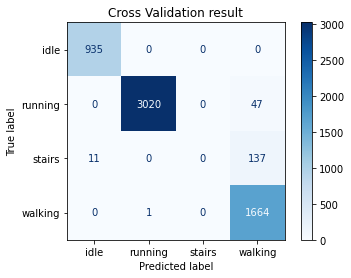

Test result score: 0.9582689335394127


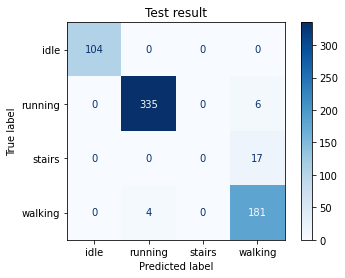

In [34]:
SVM(pca_2d_train_df, pca_2d_test_df)

Cross Validation result score: 0.9654342218400688


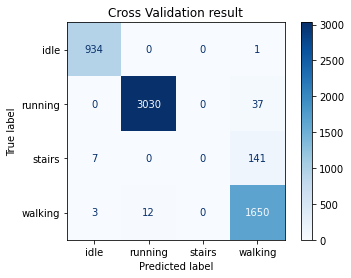

Test result score: 0.9675425038639877


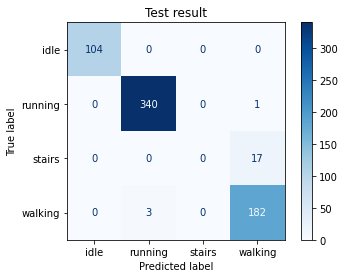

In [35]:
SVM(pca_2d_loc_mes_train_df, pca_2d_loc_mes_test_df)

<i>Decision tree</i>

In [36]:
def DecisionTree(df_train, df_test):
    cols = [col for col in df_train.columns if col.startswith('accelerometer')]
    
    X_train = df_train[cols].to_numpy()
    y_train = df_train['type'].to_numpy()   
        
    X_test = df_test[cols].to_numpy()
    y_test = df_test['type'].to_numpy()
    
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    
    DisplayInfo(X_train, y_train, clf, 'Cross Validation result', df_train['type'].unique())
    DisplayInfo(X_test, y_test, clf, 'Test result', df_train['type'].unique())  

Cross Validation result score: 1.0


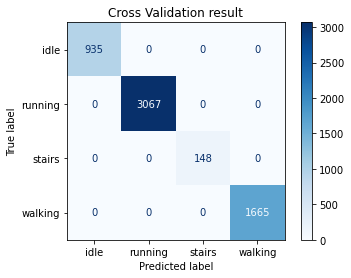

Test result score: 0.9536321483771252


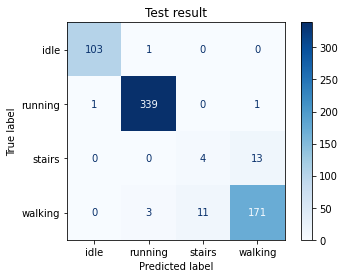

In [37]:
DecisionTree(flatten_train_df, flatten_test_df)

Cross Validation result score: 1.0


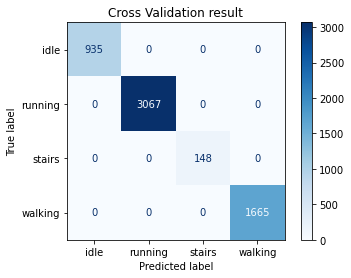

Test result score: 0.9922720247295209


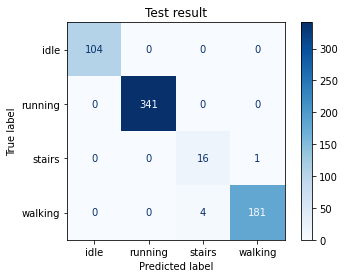

In [38]:
DecisionTree(loc_mes_train_df, loc_mes_test_df)

Cross Validation result score: 1.0


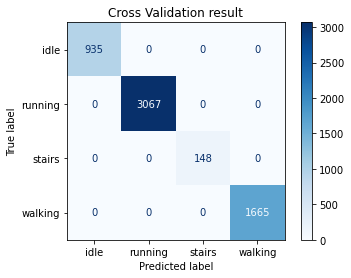

Test result score: 0.8377125193199382


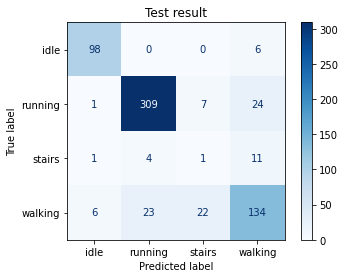

In [39]:
DecisionTree(pca_2d_train_df, pca_2d_test_df)

Cross Validation result score: 1.0


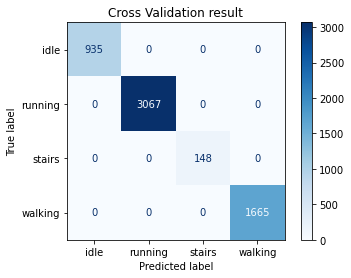

Test result score: 0.9675425038639877


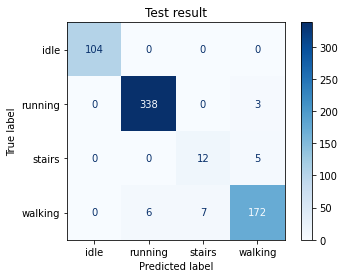

In [40]:
DecisionTree(pca_2d_loc_mes_train_df, pca_2d_loc_mes_test_df)

<i>Random forest</i>

In [41]:
def RandomForest(df_train, df_test):
    cols = [col for col in df_train.columns if col.startswith('accelerometer')]
    
    X_train = df_train[cols].to_numpy()
    y_train = df_train['type'].to_numpy()   
        
    X_test = df_test[cols].to_numpy()
    y_test = df_test['type'].to_numpy()
    
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0).fit(X_train, y_train)
    
    DisplayInfo(X_train, y_train, clf, 'Cross Validation result', df_train['type'].unique())
    DisplayInfo(X_test, y_test, clf, 'Test result', df_train['type'].unique())  

Cross Validation result score: 1.0


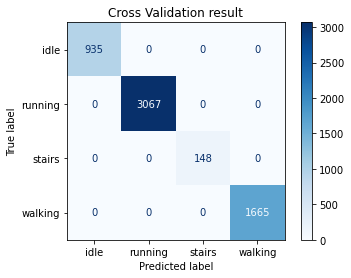

Test result score: 0.9752704791344667


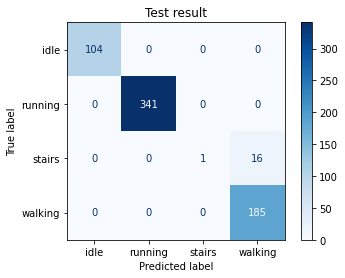

In [42]:
RandomForest(flatten_train_df, flatten_test_df)

Cross Validation result score: 1.0


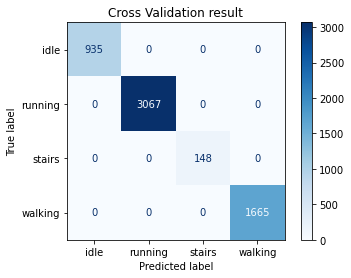

Test result score: 1.0


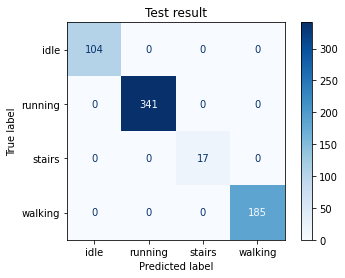

In [43]:
RandomForest(loc_mes_train_df, loc_mes_test_df)

Cross Validation result score: 1.0


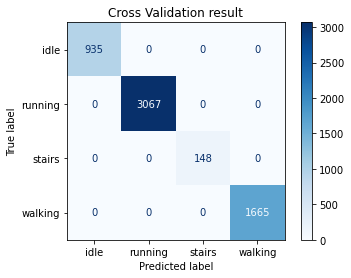

Test result score: 0.9567233384853169


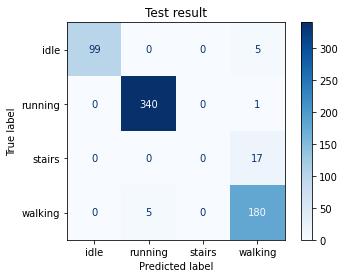

In [44]:
RandomForest(pca_2d_train_df, pca_2d_test_df)

Cross Validation result score: 1.0


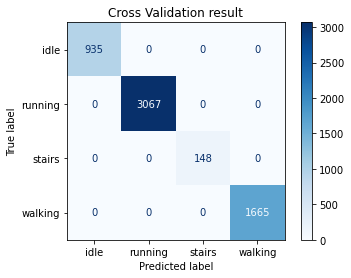

Test result score: 0.9752704791344667


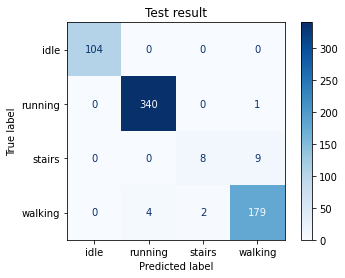

In [45]:
RandomForest(pca_2d_loc_mes_train_df, pca_2d_loc_mes_test_df)